<div style="border:solid orange 3px; padding: 16px">  
    <font size="4">  
        <p style="text-align: center;">
            <b> 5. Сборный проект #1. Продажи видеоигр </b>
        </p> 
    </font>
</div>

## 0. Описание проекта
Данные о продажах видеоигр в интернет-магазине до 2016 года (включительно). Необходимо выявить закономерности определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год.

ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## 1. Общая информация

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

path = 'C:/Users/pavel/Desktop/da/projects/datasets/'

In [2]:
# данные о продажах до 2016 в разных регионах
games = pd.read_csv (path + '05_games_data.csv')

In [3]:
# данные о возрастном рейтинге ESRB
rating = pd.read_csv (path + '05_games_rating.csv', index_col=0)

In [4]:
# выведем информацию о наборе данных
games.info()
 
# и первые строки датасета
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Описание данных:

- `Name` — название игры;
- `Platform` — платформа;
- `Year_of_Release` — год выпуска;
- `Genre` — жанр игры;
- `NA_sales` — продажи в Северной Америке (млн.);
- `EU_sales` — продажи в Европе (млн.);
- `JP_sales` — продажи в Японии (млн.);
- `Other_sales` — продажи в других странах (млн.);
- `Critic_Score` — оценка критиков (максимум 100);
- `User_Score` — оценка пользователей (максимум 10);
- `Rating` — рейтинг от организации ESRB.

---

In [5]:
rating.info()
rating

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 2 columns):
rating_type    8 non-null object
decryption     8 non-null object
dtypes: object(2)
memory usage: 192.0+ bytes


,rating_type,decryption
0,E,Для всех
1,M,От 17 лет
2,T,Подросткам 13—19 лет
3,E10+,Для всех старше 10 лет
4,K-A,Для всех(до 1998 года)
5,AO,Только для взрослых
6,EC,Для детей младшего возраста
7,RP,Рейтинг ожидается


Описание данных:

- `rating_type` — обозначение рейтинга;
- `decryption` — расшифровка.

## 2. Предобработка данных

In [6]:
# изменим названия столбцов
change_column_names_dict = {"Name" : "name",
                            "Platform" : "platform",
                            "Year_of_Release" : "year_of_release",
                            "Genre" : "genre",
                            "Other_sales" : "other_sales",
                            "Critic_Score" : "critic_score",
                            "User_Score" : "user_score",
                            "Rating" : "rating"}

games = games.rename(columns = change_column_names_dict)

In [7]:
# добавим столбец с общим количеством продаж (в млн.)
games['overall_sales'] = games['NA_sales'] + games['EU_sales'] + games['JP_sales'] + games['other_sales']

Рассмотрим записи с пропущенным названием игры.

In [8]:
games['name'].isnull().sum()

2

In [9]:
games[games['name'].isnull() == True]

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,overall_sales
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


In [10]:
# удалим эти записи, т.к. невозможно восстановить информацию
games = games.dropna(subset=['name']).reset_index(drop = 'True')

---

Удалим (заменим на NaN) значения `tbd` ("to be done") в столбце `user_score`, поскольку эти значения не дают никакой дополнительной информации и всё ещё являются неизвестными.

Остальные пропуски (`critic_score`, `user_score`, `raiting`) нельзя заполнить, используя значения других столбцов, поэтому оставим их без изменений.

In [11]:
games.loc[games.loc[:,'user_score'] == 'tbd', 'user_score'] = np.nan

Приведем данные в столбце с годом выпуска к целочисленному типу `Int64`, а в столбце с оценкой пользователей к численному типу.

In [12]:
games['year_of_release'] = games['year_of_release'].astype('Int64')
games['user_score'] = pd.to_numeric(games['user_score'])

Изменим порядок столбцов в датасете.

In [13]:
games = games[['name', 'platform', 'year_of_release', 'genre', 'overall_sales', 
               'NA_sales', 'EU_sales', 'JP_sales', 'other_sales', 'critic_score',
               'user_score', 'rating']]

In [14]:
games.head()

,name,platform,year_of_release,genre,overall_sales,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,82.54,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,40.24,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,35.52,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,32.77,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,31.38,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [15]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null Int64
genre              16713 non-null object
overall_sales      16713 non-null float64
NA_sales           16713 non-null float64
EU_sales           16713 non-null float64
JP_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.5+ MB


## 3. Исследовательский анализ данных

### 3.1 Динамика выпуска игр

Построим распределение количества игр по году выпуска.

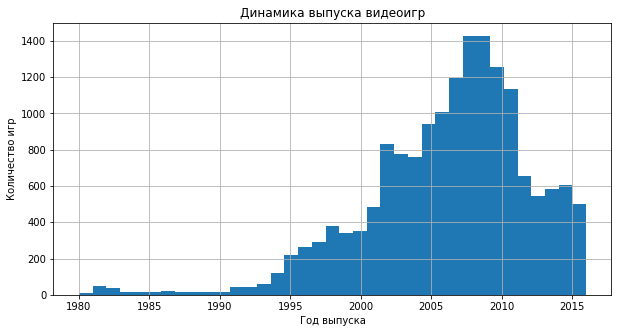

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


In [16]:
f, ax = plt.subplots(figsize=(10, 5))

games['year_of_release'].hist(bins = len(games['year_of_release'].unique())-1, ax=ax)

ax.set(xlabel = 'Год выпуска', ylabel = 'Количество игр', 
       title = 'Динамика выпуска видеоигр')
plt.show()

# количество игр, выпущенных в разные годы (суммарно по всем платформам)
games.pivot_table(index='year_of_release', values='name', aggfunc = 'count')

В 2008 было выпущено наибольшее количество игр (1427), после чего количество игр падает, и к 2016 года достигает значения около 500 в год.

### 3.2 Динамика продаж по платформам

Рассмотрим, для каких платформ выпускались игры.

In [17]:
games['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

Имеется информация о продажах видеоигр для 31 платформы.

Рассмотрим суммарные (по всем странам) продажи игр для разных платформ.

In [18]:
# количество проданных копий игр (в млн.)
games.groupby(by = 'platform')['overall_sales'].sum().sort_values(ascending = False)

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: overall_sales, dtype: float64

Рассмотрим динамику продаж для первых 15 платформ по количеству общих продаж.

In [19]:
# список 15 платформ с наибольшим количеством продаж
platform_top15 = games.groupby(by = 'platform')['overall_sales'].sum().sort_values(ascending = False).head(15).index
platform_top15

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC',
       '3DS', 'XB', 'GB', 'NES', 'N64'],
      dtype='object', name='platform')

In [20]:
# выделим в отдельный датасет игры для платформ из топ-15 по суммарным продажам
games_platform_top15 = games[games['platform'].isin(platform_top15)]

Оставим только те игры, у которых известен год выпуска.

In [21]:
games_platform_top15 = games_platform_top15.dropna(subset=['year_of_release']).reset_index(drop = 'True')

In [22]:
games_platform_top15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14441 entries, 0 to 14440
Data columns (total 12 columns):
name               14441 non-null object
platform           14441 non-null object
year_of_release    14441 non-null Int64
genre              14441 non-null object
overall_sales      14441 non-null float64
NA_sales           14441 non-null float64
EU_sales           14441 non-null float64
JP_sales           14441 non-null float64
other_sales        14441 non-null float64
critic_score       7154 non-null float64
user_score         6668 non-null float64
rating             8856 non-null object
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.3+ MB


In [23]:
# суммарные продажи (млн. копий игр) для разных платформ по годам выпуска
sales_platform_top15 = games_platform_top15.\
                       pivot_table(index='year_of_release', 
                                   columns='platform', 
                                   values='overall_sales', 
                                   aggfunc='sum', fill_value=0)

In [24]:
sales_platform_top15.head()

platform,3DS,DS,GB,GBA,N64,NES,PC,PS,PS2,PS3,PS4,PSP,Wii,X360,XB
year_of_release,,,,,,,,,,,,,,,
1983,0.0,0.00,0.0,0.0,0.0,10.96,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.00,0.0,0.0,0.0,50.08,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985,0.0,0.02,0.0,0.0,0.0,53.44,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,0.0,0.00,0.0,0.0,0.0,36.41,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.00,0.0,0.0,0.0,19.76,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


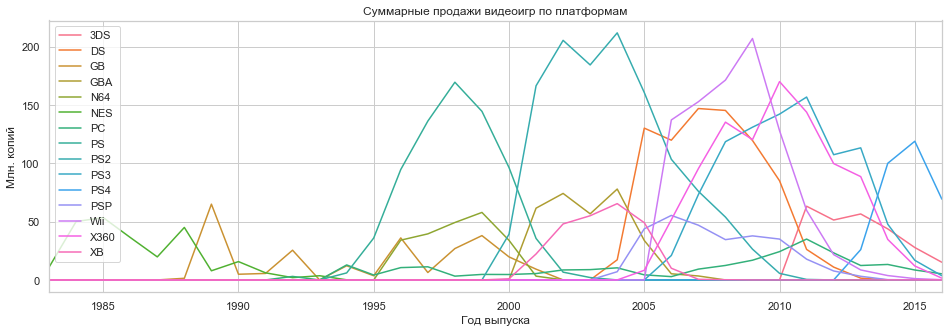

In [25]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 5))

sns.lineplot(data = sales_platform_top15, dashes = False)
ax.set(xlabel = 'Год выпуска', ylabel = 'Млн. копий', 
       title = 'Суммарные продажи видеоигр по платформам',
       xlim = (1983, 2016))

plt.show()

Видим, что количество проданных игр, выпущенных в течении 3-4 лет после появления новой платформы, растет; игры выпущенные в следующие 1-2 года продаются лучше всего; и игры выпущенные в следующие 3-4 года продаются хуже и хуже с каждым годом.

---

Для построения прогноза на 2017 год ограничимся данными за последние 5 лет, так мы сможем увидеть, какие платформы развиваются и являются перспективными (продажи игр для этих платформ растут), а какие уже выходят из моды.

In [26]:
games.head()

,name,platform,year_of_release,genre,overall_sales,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,82.54,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,40.24,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,35.52,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,32.77,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,31.38,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [27]:
# выделим в отдельный набор данных игры выпущенные в 2012 и позже
games_after_2011 = games[games['year_of_release'] > 2011]

In [28]:
games_after_2011.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2886 entries, 16 to 16712
Data columns (total 12 columns):
name               2886 non-null object
platform           2886 non-null object
year_of_release    2886 non-null Int64
genre              2886 non-null object
overall_sales      2886 non-null float64
NA_sales           2886 non-null float64
EU_sales           2886 non-null float64
JP_sales           2886 non-null float64
other_sales        2886 non-null float64
critic_score       1312 non-null float64
user_score         1531 non-null float64
rating             1611 non-null object
dtypes: Int64(1), float64(7), object(4)
memory usage: 295.9+ KB


Рассмотрим суммарные продажи по платформам в динамике за последние 5 лет.

In [29]:
# количество проданных копий игр (в млн.)
games_after_2011.groupby(by = 'platform')['overall_sales'].sum().sort_values(ascending = False)

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
PSP      11.19
Name: overall_sales, dtype: float64

Построим график суммарных продаж в год по платформам за последние 5 лет.

In [30]:
# суммарные продажи (млн. копий) для игр выпущенных в каждом году по платформам
sales_platform_after_2011 = games_after_2011.\
                            pivot_table(index='year_of_release', 
                                        columns=['platform'], 
                                        values='overall_sales', 
                                        aggfunc='sum', fill_value=0)

In [31]:
sales_platform_after_2011

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,0.00,7.69,16.19,21.71,17.56,99.74,0.00
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,0.00,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,0.00,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,0.00,5.25,3.60,69.25,0.00,4.25,0.18,4.60,1.52,26.15


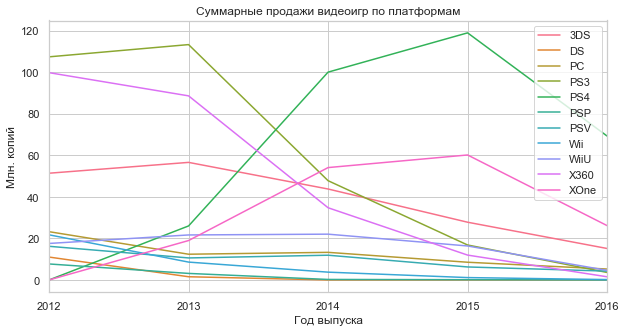

In [32]:
f, ax = plt.subplots(figsize=(10, 5))

# линейный график суммарных продаж для игр выпущенных в каждом году по платформам
sns.lineplot(data = sales_platform_after_2011, dashes = False)
ax.set(xlabel = 'Год выпуска', ylabel = 'Млн. копий', 
       title = 'Суммарные продажи видеоигр по платформам',
       xlim = (2012, 2016))

plt.xticks((2012, 2013, 2014, 2015, 2016))
plt.show()

Игры, выпущенные в последние годы для платформ `PS4` и `Xbox One`, продаются лучше всего. Относительно низкое количество проданных игр, которые были выпущены в 2016 году, можно объяснить тем, что прошло недостаточно времени для покупки. Скорее всего, эти игры ещё будут покупать в следующем году. 

Для остальных платформ продажи выпускаемых игр год за годом падают.

### 3.3 Распределение суммарных продаж по платформам

Рассмотрим, как распределено суммарное количество проданных копий внутри каждой платформы. Учитываем только игры, выпущенные в 2012 и позже.

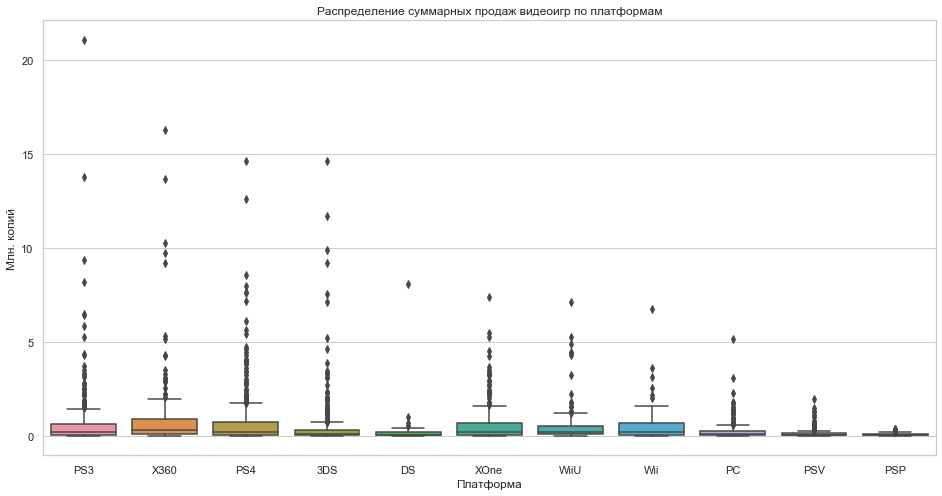

In [33]:
f, ax = plt.subplots(figsize=(16, 8))

# боксплоты для суммарных продаж игр за последние 5 лет по платформам
sns.boxplot(x = "platform", y = "overall_sales", data = games_after_2011)

ax.set(xlabel = 'Платформа', ylabel = 'Млн. копий', 
       title = 'Распределение суммарных продаж видеоигр по платформам')
plt.show()

In [34]:
# числовые характеристики распределения суммарных продаж игр за последние 5 лет
games_after_2011.groupby('platform')['overall_sales'].describe().round(3).sort_values('max', ascending = False)

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PS3,493.0,0.586,1.463,0.01,0.050,0.20,0.610,21.05
X360,292.0,0.810,1.712,0.01,0.100,0.31,0.870,16.27
PS4,392.0,0.801,1.609,0.01,0.060,0.20,0.730,14.63
3DS,396.0,0.491,1.387,0.01,0.040,0.11,0.313,14.60
DS,31.0,0.405,1.439,0.01,0.020,0.05,0.185,8.06
XOne,247.0,0.645,1.036,0.01,0.060,0.22,0.685,7.39
WiiU,147.0,0.559,1.059,0.01,0.080,0.22,0.525,7.09
Wii,54.0,0.655,1.165,0.01,0.062,0.18,0.688,6.76
PC,250.0,0.251,0.495,0.01,0.030,0.08,0.240,5.14


У 4-х из 5 первых платформ по количеству проданных игр (`PS3`, `X360`, `PS4`, `3DS`) есть несколько выбросов - игры, проданные больше 10 млн раз. Возможно, эти хиты и принесли популярность платформам.

Для всех платформ среднее количество проданных копий игр больше медианы в 2-4 раза и для некоторых платформ среднее значение приблизительно равно 3-му квартилю, это говорит о сильном влиянии выбросов - очень популярных игр, и о большом количестве относительно непопулярных игр.

### 3.4 Корреляция продаж и отзывов

На примере платформы X360 и игр для неё, выпущенных за последние 5 лет, рассмотрим связь количества проданных копий игры и оценки критиков/ пользователей.

In [35]:
# набор данных с играми для Xbox 360, выпущенными в 2012 году и позже
games_x360_after_2011 = games_after_2011.query("platform == 'X360'")
games_x360_after_2011.head()

,name,platform,year_of_release,genre,overall_sales,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating
23,Grand Theft Auto V,X360,2013,Action,16.27,9.66,5.14,0.06,1.41,97.0,8.1,M
35,Call of Duty: Black Ops II,X360,2012,Shooter,13.68,8.25,4.24,0.07,1.12,83.0,4.8,M
60,Call of Duty: Ghosts,X360,2013,Shooter,10.24,6.73,2.56,0.04,0.91,73.0,2.6,M
66,Halo 4,X360,2012,Shooter,9.71,6.65,2.28,0.04,0.74,87.0,7.0,M
72,Minecraft,X360,2013,Misc,9.18,5.70,2.65,0.02,0.81,NaN,NaN,NaN


In [36]:
games_x360_after_2011.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 23 to 16652
Data columns (total 12 columns):
name               292 non-null object
platform           292 non-null object
year_of_release    292 non-null Int64
genre              292 non-null object
overall_sales      292 non-null float64
NA_sales           292 non-null float64
EU_sales           292 non-null float64
JP_sales           292 non-null float64
other_sales        292 non-null float64
critic_score       171 non-null float64
user_score         235 non-null float64
rating             244 non-null object
dtypes: Int64(1), float64(7), object(4)
memory usage: 29.9+ KB


In [37]:
# к. корреляции для суммарных продаж, оценок критиков и оценок пользователей
# в оценках есть пропуски, но метод .corr() не включает в расчет строки с пропусками
games_x360_after_2011[['overall_sales', 'critic_score', 'user_score']].corr().round(3)

,overall_sales,critic_score,user_score
overall_sales,1.000,0.361,0.006
critic_score,0.361,1.000,0.557
user_score,0.006,0.557,1.000


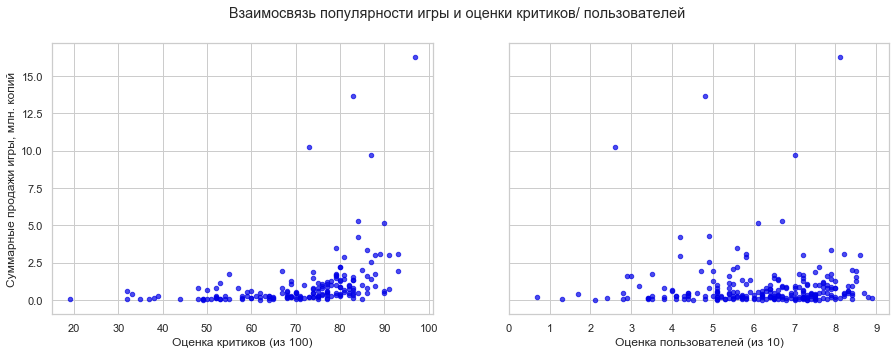

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# диаграмма рассеяния "оценка критиков" - "суммарные продажи"
games_x360_after_2011.plot(x='critic_score', y = 'overall_sales', kind='scatter', 
                           sharex=False, grid=True, alpha = .7,  
                           c=np.array([0.0, 0.0, 0.9]).reshape(1,-1), ax = axs[0])
axs[0].set(xlabel = 'Оценка критиков (из 100)', ylabel = 'Суммарные продажи игры, млн. копий')

# диаграмма рассеяния "оценка пользователей" - "суммарные продажи"
games_x360_after_2011.plot(x='user_score', y = 'overall_sales', kind='scatter', 
                           sharex=False, grid=True, alpha = .7,
                           c=np.array([0.0, 0.0, 0.9]).reshape(1,-1), ax = axs[1])
axs[1].set(xlabel = 'Оценка пользователей (из 10)')
plt.xticks(range(0,10))

fig.suptitle('Взаимосвязь популярности игры и оценки критиков/ пользователей')
plt.show() 

На примере игр для Xbox 360, выпущенных после 2012 года, видим, что нет сильно выраженной линейной зависимости между оценкой критиков (и оценкой пользователей) и количеством проданных копий игры.

### 3.5 Распределение игр по жанрам

Рассмотрим, как распределены суммарные продажи видеоигр в зависимости от жанра.

In [39]:
# количество игр выпущенных после 2011 года по жанрам
games_after_2011['genre'].value_counts()

Action          1031
Role-Playing     370
Adventure        302
Sports           268
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64

In [40]:
# количество проданных копий игр (в млн.) по жанрам
games_after_2011.groupby(by = 'genre')['overall_sales'].sum().sort_values(ascending = False)

genre
Action          441.12
Shooter         304.73
Role-Playing    192.80
Sports          181.07
Misc             85.04
Platform         61.00
Racing           53.50
Fighting         44.49
Simulation       35.12
Adventure        29.43
Strategy         13.34
Puzzle            4.89
Name: overall_sales, dtype: float64

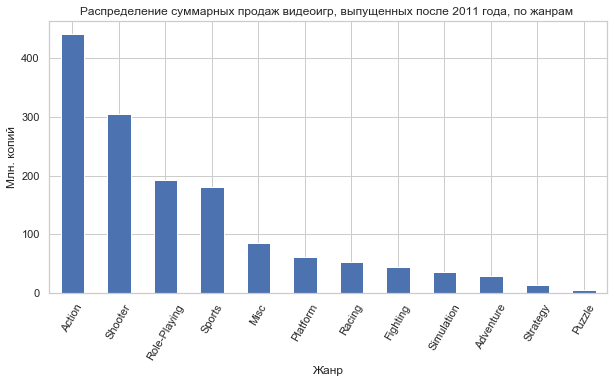

In [41]:
# столбчатая диграмма с объёмом продаж в каждом жанре
ax = games_after_2011.groupby(by = 'genre')['overall_sales'].sum().sort_values(ascending = False)\
     .plot(x = 'genre', kind = 'bar', legend = False, grid = True, figsize = (10,5))

ax.set(xlabel = 'Жанр', ylabel = 'Млн. копий', 
       title = 'Распределение суммарных продаж видеоигр, выпущенных после 2011 года, по жанрам ')
plt.xticks(rotation = 60)
plt.show()

Самые продаваемые жанры:
- Action
- Shooter
- Role-playing.

Самые непопулярные жанры:
- Puzzle
- Strategy
- Adventure.

## 4. Портрет пользователей отдельного региона 
Для 3-х регионов продаж (NA, EU, JP) выделим самые популярные платформы и самые популярные жанры. Будем использовать данные об играх, выпущенных за последние 5 лет.

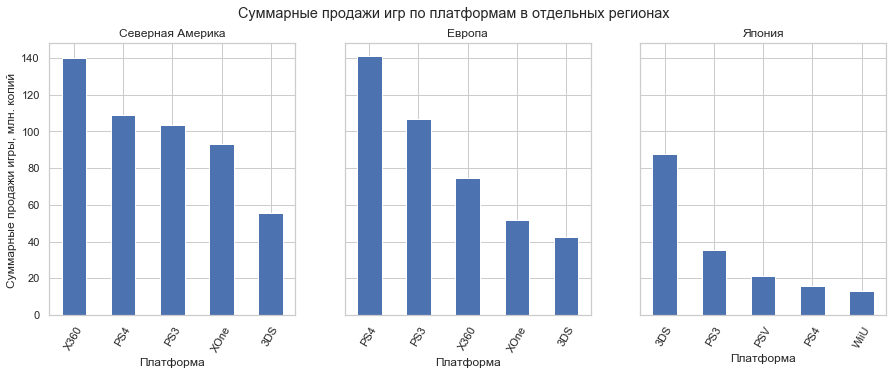

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# сгруппируем по платформе и просуммируем продажи внутри каждого региона
games_after_2011.groupby(by = 'platform')['NA_sales'].sum().sort_values(ascending = False).head(5)\
     .plot(x = 'genre', kind = 'bar', legend = False, grid = True, ax = axs[0])

axs[0].set(xlabel = 'Платформа', ylabel = 'Суммарные продажи игры, млн. копий ',
           title = 'Северная Америка')
axs[0].tick_params('x', labelrotation=60)

games_after_2011.groupby(by = 'platform')['EU_sales'].sum().sort_values(ascending = False).head(5)\
     .plot(x = 'genre', kind = 'bar', legend = False, grid = True, ax = axs[1])

axs[1].set(xlabel = 'Платформа', title = 'Европа')
axs[1].tick_params('x', labelrotation=60)


games_after_2011.groupby(by = 'platform')['JP_sales'].sum().sort_values(ascending = False).head(5)\
     .plot(x = 'genre', kind = 'bar', legend = False, grid = True, ax = axs[2])

axs[2].set(xlabel = 'Платформа', title = 'Япония')
axs[2].tick_params('x', labelrotation=60)

fig.suptitle('Суммарные продажи игр по платформам в отдельных регионах')
plt.show() 

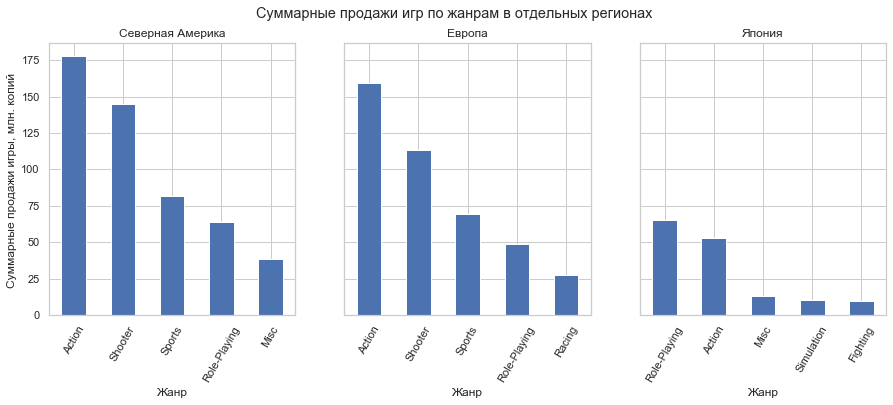

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# сгруппируем по жанру и просуммируем продажи внутри каждого региона
games_after_2011.groupby(by = 'genre')['NA_sales'].sum().sort_values(ascending = False).head(5)\
     .plot(x = 'genre', kind = 'bar', legend = False, grid = True, ax = axs[0])

axs[0].set(xlabel = 'Жанр', ylabel = 'Суммарные продажи игры, млн. копий ',
           title = 'Северная Америка')
axs[0].tick_params('x', labelrotation=60)

games_after_2011.groupby(by = 'genre')['EU_sales'].sum().sort_values(ascending = False).head(5)\
     .plot(x = 'genre', kind = 'bar', legend = False, grid = True, ax = axs[1])

axs[1].set(xlabel = 'Жанр', title = 'Европа')
axs[1].tick_params('x', labelrotation=60)


games_after_2011.groupby(by = 'genre')['JP_sales'].sum().sort_values(ascending = False).head(5)\
     .plot(x = 'genre', kind = 'bar', legend = False, grid = True, ax = axs[2])

axs[2].set(xlabel = 'Жанр', title = 'Япония')
axs[2].tick_params('x', labelrotation=60)

fig.suptitle('Суммарные продажи игр по жанрам в отдельных регионах')
plt.show() 

Рассмотрим продажи видеоигр с разным рейтингом ESRB в отдельных регионах.

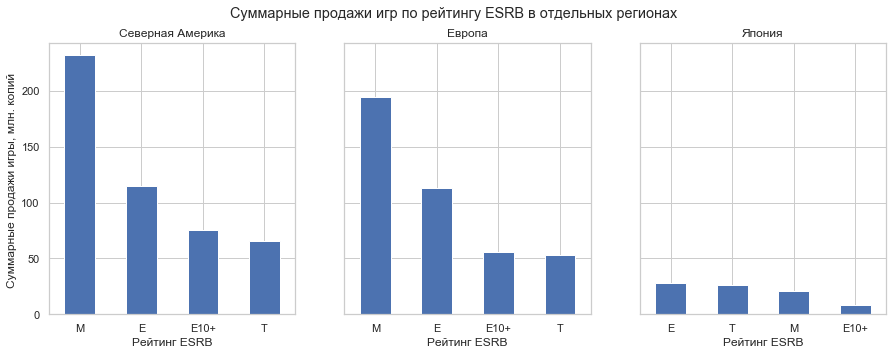

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# сгруппируем по рейтингу и просуммируем продажи для каждого региона
games_after_2011.groupby(by = 'rating')['NA_sales'].sum().sort_values(ascending = False).head(5)\
     .plot(x = 'genre', kind = 'bar', legend = False, grid = True, ax = axs[0])

axs[0].set(xlabel = 'Рейтинг ESRB', ylabel = 'Суммарные продажи игры, млн. копий ',
           title = 'Северная Америка')
axs[0].tick_params('x', labelrotation=0)

games_after_2011.groupby(by = 'rating')['EU_sales'].sum().sort_values(ascending = False).head(5)\
     .plot(x = 'genre', kind = 'bar', legend = False, grid = True, ax = axs[1])

axs[1].set(xlabel = 'Рейтинг ESRB', title = 'Европа')
axs[1].tick_params('x', labelrotation=0)


games_after_2011.groupby(by = 'rating')['JP_sales'].sum().sort_values(ascending = False).head(5)\
     .plot(x = 'genre', kind = 'bar', legend = False, grid = True, ax = axs[2])

axs[2].set(xlabel = 'Рейтинг ESRB', title = 'Япония')
axs[2].tick_params('x', labelrotation=0)

fig.suptitle('Суммарные продажи игр по рейтингу ESRB в отдельных регионах')
plt.show() 

In [45]:
rating

,rating_type,decryption
0,E,Для всех
1,M,От 17 лет
2,T,Подросткам 13—19 лет
3,E10+,Для всех старше 10 лет
4,K-A,Для всех(до 1998 года)
5,AO,Только для взрослых
6,EC,Для детей младшего возраста
7,RP,Рейтинг ожидается


Наиболее продаваемые игры в Северной Америке:
- для платформ X360, PS4, PS3
- жанр Action, Shooter, Sports
- с рейтингом ESRB: M, E, E10+.

Наиболее продаваемые игры в Европе:
- для платформ PS4, PS3, X360
- жанр Action, Shooter, Sports
- с рейтингом ESRB: M, E, E10+.

Наиболее продаваемые игры в Японии:
- для платформ 3DS, PS3, PSV
- жанр Role-playng, Action, Misc
- с рейтингом ESRB: E, T, M.

## 5. Проверка гипотез
Сравним средние пользовательские рейтинги на платформах PC и Xbox One, и рейтинги для жанров Action и Sports.

Сформулируем нулевую гипотезу: "Средние пользовательские рейтинги на платформах PC и Xbox One - одинаковые".

In [46]:
# выделим игры с оценкой пользователя в отдельный датасет
games_with_user_scores = games[games['user_score'].isna() == False]\
[['name', 'user_score', 'platform', 'genre']].reset_index(drop = True)
games_with_user_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7590 entries, 0 to 7589
Data columns (total 4 columns):
name          7590 non-null object
user_score    7590 non-null float64
platform      7590 non-null object
genre         7590 non-null object
dtypes: float64(1), object(3)
memory usage: 237.3+ KB


In [47]:
games_with_user_scores.head()

,name,user_score,platform,genre
0,Wii Sports,8.0,Wii,Sports
1,Mario Kart Wii,8.3,Wii,Racing
2,Wii Sports Resort,8.0,Wii,Sports
3,New Super Mario Bros.,8.5,DS,Platform
4,Wii Play,6.6,Wii,Misc


In [48]:
# средний пользовательский рейтинг игр на платформе PC
games_with_user_scores.query('platform == "PC"')['user_score'].mean()

7.062467532467546

In [49]:
# средний пользовательский рейтинг игр на платформе Xbox One
games_with_user_scores.query('platform == "XOne"')['user_score'].mean()

6.52142857142857

In [50]:
# зададим критический уровень статистической значимости в 5%
alpha = .05 

# по Т-критерию Стьюдента сравним средние значения двух наборов данных:
# оценки пользователей для игр на платформе PC и на платформе Xbox One
results = st.ttest_ind(
    games_with_user_scores.query('platform == "PC"')['user_score'], 
    games_with_user_scores.query('platform == "XOne"')['user_score'],
    equal_var = True)

print('p-значение:', results.pvalue)

p-значение: 1.3896435533548819e-05


Уровень статистической значимости ниже критического, отвергаем нулевую гипотезу, делаем вывод о том, что средние пользовательские рейтинги для игр на платфомах PC и Xbox One не равны.


---

Сформулируем нулевую гипотезу: "Средние пользовательские рейтинги для игр жанра Action и Sports - одинаковые".

In [51]:
# средний пользовательский рейтинг игр жанра Action
games_with_user_scores.query('genre == "Action"')['user_score'].mean()

7.054043715846988

In [52]:
# средний пользовательский рейтинг игр жанра Sports
games_with_user_scores.query('genre == "Sports"')['user_score'].mean()

6.961196736174073

In [53]:
# зададим критический уровень статистической значимости в 5%
alpha = .05 

# по Т-критерию Стьюдента сравним средние значения двух наборов данных:
# оценки пользователей для игр жанра Action и Sports
results = st.ttest_ind(
    games_with_user_scores.query('genre == "Action"')['user_score'], 
    games_with_user_scores.query('genre == "Sports"')['user_score'],
    equal_var = False)

print('p-значение:', results.pvalue)

p-значение: 0.11483818791498286


Уровень статистической значимости выше критического. Нет оснований для того, чтобы отвергнуть нулевую гипотезу.

Делаем вывод о том, что средние пользовательские рейтинги для игр жанра Action и Sports - равны.

## 6. Выводы

1. В рекламных кампаниях следующего года стоит сосредоточиться на играх для платформ PS4 и Xbox One.
2. Самые популярные жанры игр в последние 5 лет: Action, Shooter, Role-playing.
3. При планировании рекламных кампаний следует учитывать региональные особенности.
4. Оценки критиков и оценки пользователей слабо связаны с количеством проданных копий игры.